### **Physics-informed DeepONet**

In [3]:
import numpy as np  
import matplotlib.pyplot as plt  

import tensorflow as tf  
from tensorflow import keras  
tf.random.set_seed(42)

**Definimos la arquitectura**

1. Se asume que las redes trunk y branch son fully connected networks con 3 hidden layers, cada uno de los hidden conteniendo 50 neuronas y la función de activación TanH. 

2. Las outputs de la red trunk y la red branch se concatenan por medio de un producto punto. Como se sugiere en el paper de la arquitectura DeepONet, se debe añadir un término de BiasLayer para mejorar la precisión de predicción.

In [4]:
class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(
            shape=(1,),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True
        )
    
    def call(self, inputs):
        return inputs + self.bias

In [5]:
def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.
    
    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the DeepONet model
    """
    # Branch Net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(3):
        branch = tf.keras.layers.Dense(50, activation="tanh")(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(3):
        trunk = tf.keras.layers.Dense(50, activation="tanh")(trunk)

    # Dot product (branch * trunk)
    dot_product = tf.reduce_sum(tf.multiply(branch, trunk), axis=1, keepdims=True)

    # Bias Layer
    output = BiasLayer()(dot_product)

    # Modelo
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()
    
    return model

**Definimos la función de pérdida para las ecuaciones diferenciales**

1. Se utiliza tf.GradientTape() para calcular el gradiente de s(.) con respecto a t. tf.GradientTape() se utiliza como un gestor de contexto, y cualquier operación ejecutada dentro del contexto será registrada. Aquí, observamos explícitamente la variable t. Como resultado, TensorFlow rastreará automáticamente todas las operaciones que involucren a t, que en este caso, es una ejecución hacia adelante (feedforward) del modelo DeepONet. Después, utilizamos el método gradient() de tape para calcular el gradiente de s(.) con respecto a t.

2. Incluimos un argumento de entrada extra u_t, que denota el valor de la función de entrada u(.) evaluada en t. Esto constituye el término del lado derecho de nuestra ODE objetivo, y es necesario para calcular la pérdida residual de la ODE.

3. Utilizamos el decorador @tf.function para convertir la función regular de Python que acabamos de definir en un grafo TensorFlow. Es útil hacerlo ya que el cálculo del gradiente puede ser bastante costoso y ejecutarlo en modo gráfico puede acelerar significativamente los cálculos.

In [6]:
@tf.function
def ODE_residual_calculator(t, u, u_t, model):
    """ODE residual calculation.
    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    ----
    ODE_residual: residual of the governing ODE
    """
    with tf.GradientTape() as tape:
        tape.watch(t)  
        s = model({"forcing": u, "time": t})

    # Gradientes
    ds_dt = tape.gradient(s, t) 

    # ODE residual
    ODE_residual = ds_dt - u_t

    return ODE_residual        

**Descenso del gradiente**

1. Sólo consideramos dos términos de pérdida: la pérdida asociada a la condición inicial IC_loss, y la pérdida residual ODE ODE_loss. La pérdida IC se calcula comparando la s(t=0) predicha por el modelo con el valor inicial conocido de 0, y la pérdida ODE se calcula llamando a nuestra función ODE_residual_calculator definida previamente. La pérdida de datos también puede calcularse y añadirse a la pérdida total si se dispone de los valores s(t) medidos (no implementados en el código anterior).

2. En general, la pérdida total es una suma ponderada de IC_loss y ODE_loss, donde los pesos controlan cuánto énfasis o prioridad se da a los términos de pérdida individuales durante el proceso de entrenamiento. En nuestro caso de estudio, basta con establecer tanto IC_weight como ODE_weight como 1.

3. De forma similar a cómo calculamos ODE_loss, también adoptamos tf.GradientTape() como gestor de contexto para calcular los gradientes. Sin embargo, aquí calculamos los gradientes de la pérdida total con respecto a los parámetros del modelo de red, que son necesarios para realizar el descenso de gradiente.

In [7]:
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        # Eq. residual
        ODE_residual = ODE_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Loss function
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))

        # Concatenate loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight
    
    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, total_loss, gradients

### **Generación de datos**

Los datos utilizados para el entrenamiento, la validación y las pruebas se generarán sintéticamente. La razón de ser de este enfoque es doble: no sólo es cómodo, sino que además permite controlar totalmente las características de los datos.

Se genera una función de entrada u(.) utilizando un proceso Gaussiano zero-mean con una función de base (RBF).

Un proceso gaussiano es un potente framework matemático utilizado habitualmente en el aprendizaje automático para modelar funciones. El núcleo RBF es una opción popular para capturar la similitud entre los puntos de entrada. Al utilizar el kernel RBF dentro del Proceso Gaussiano, nos aseguramos de que los datos sintéticos generados muestren un patrón suave y continuo, que a menudo es deseable en diversas aplicaciones.

1. Utilizamos length_scale para controlar la forma de la función generada. 

2. Recordemos que tenemos que discretizar u(.) antes de introducirlo en DeepONet. Esto se hace especificando una variableX_sample, que asigna 100 puntos distribuidos uniformemente dentro de nuestro dominio temporal de interés.

3. En scikit-learn, el objeto GaussianProcessRegressor expone un método sample_y que permite extraer muestras aleatorias del proceso gaussiano con el kernel especificado en la escala de longitud. Observe que no hemos llamado a .fit() antes de utilizar el objeto GaussianProcessRegressor, a diferencia de lo que hacemos normalmente con otros regresores de scikit-learn. Esto es intencional, ya que queremos que GaussianProcessRegressor utilice la length_scale exacta que proporcionamos. Si llama a .fit() , la length_scale se optimizará a otro valor para ajustarse mejor a cualquier dato que se proporcione.

4. La salida u_sample es una matriz con una dimensión de sample_num * 100. Cada fila de u_sample representa un perfil de u(.), que consta de 100 valores discretos.

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import random

def create_samples(length_scale, sample_num):
    """Create synthetic data for u(·)
    
    Args:
    ----
    length_scale: float, length scale for RNF kernel
    sample_num: number of u(·) profiles to generate
    
    Outputs:
    --------
    u_sample: generated u(·) profiles
    """
    # Kernel
    kernel = RBF(length_scale)

    # Gaussian process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Points locations
    X_sample = np.linspace(0, 1, 100).reshape(-1, 1)

    # Samples
    u_sample = np.zeros((sample_num, 100))
    for i in range(sample_num):
        n = np.random.randint(0, 10000)
        u_sample[i, :] = gp.sample_y(X_sample, random_state=n).flatten()
    return u_sample

Recordemos que la DeepONet requiere 3 entradas:

1. La coordenada t del tiempo, que es un escalar entre 0 y 1.
2. El perfil de u(.), el cual es un vector que consiste en u(.) valores, valores fijos entre 0 y 1.
3. El valor de u(t), que es un escalar. Este u(t) es usado para calcular la función de pérdida de la ODE.

In [9]:
from tqdm import tqdm
from scipy.integrate import solve_ivp

def generate_dataset(N, length_scale, ODE_solve=False):
    """Generate dataset for Physics-informed DeepONet training.
    
    Args:
    ----
    N: int, number of u(·) profiles
    length_scale: float, length scale for RNF kernel
    ODE_solve: boolean, indicate whether to compute the corresponding s(·)
    
    Outputs:
    --------
    X: the dataset for t, u(·) profiles, and u(t)
    y: the dataset for the corresponding ODE solution s(·)
    """
    # Random fields
    random_field = create_samples(length_scale, N)

    # Compile dataset
    X = np.zeros((N*100, 100+2))
    y = np.zeros((N*100, 1))

    for i in tqdm(range(N)):
        u = np.tile(random_field[i, :], (100, 1))
        t = np.linspace(0, 1, 100).reshape(-1, 1)

        # u(.) evaluated at t
        u_t = np.diag(u).reshape(-1, 1)

        # Update matrix
        X[i*100: (i+1)*100, :] = np.concatenate((t, u, u_t), axis=1)

        # ODE:
        if ODE_solve:
            sol = solve_ivp(lambda var_t, var_s: np.interp(var_t, t.flatten(), random_field[i, :]),
                            t_span=[0, 1], y0=[0], t_eval=t.flatten(), method='RK45')
            y[i*100:(i+1)*100, :] = sol.y[0].reshape(-1, 1)
    return X, y

In [10]:
# Training dataset
N_train = 2000
length_scale_train = 0.4
X_train, y_train = generate_dataset(N_train, length_scale_train)

# Validation
N_val = 100
length_scale_test = 0.4
X_val, y_val = generate_dataset(N_val, length_scale_test)

# Testing
N_test = 100
length_scale_test = 0.4
X_test, y_test = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 719.43it/s]


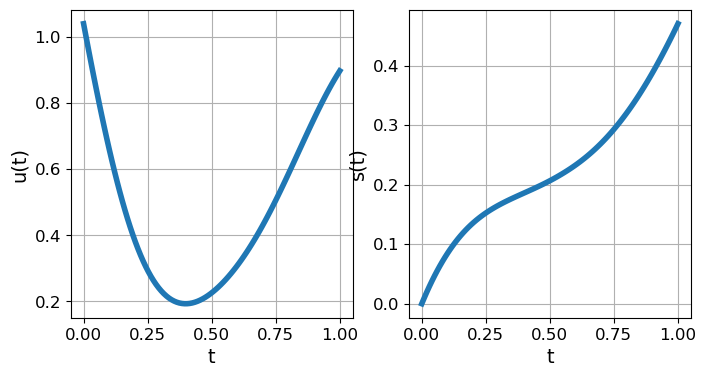

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
index = 25
ax[0].plot(np.linspace(0, 1, 100), X_test[index*100, 1:-1], lw=4)
ax[0].set_xlabel('t', fontsize=14)
ax[0].set_ylabel('u(t)', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid(True)

ax[1].plot(np.linspace(0, 1, 100), y_test[index*100:(index+1)*100], lw=4)
ax[1].set_xlabel('t', fontsize=14)
ax[1].set_ylabel('s(t)', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid(True)

In [12]:
# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.shuffle(100000).batch(col_batch_size)

# Scaling 
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

### **Training DeepONet**

In [13]:
from collections import defaultdict

class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())

In [14]:
# Set up training configurations
n_epochs = 300
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Instantiate the PINN model
PI_DeepONet= create_model(mean, var)
PI_DeepONet.compile(optimizer=optimizer)
  
# Configure callbacks
_callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=30),
             tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
callbacks = tf.keras.callbacks.CallbackList(
                _callbacks, add_history=False, model=PI_DeepONet)

# Start training process
for epoch in range(1, n_epochs + 1):  
    print(f"Epoch {epoch}:")

    for X_init, X in zip(ini_ds, train_ds):
        
        # Calculate gradients
        ODE_loss, IC_loss, total_loss, gradients = train_step(X, X_init, 
                                                            IC_weight, ODE_weight,
                                                            PI_DeepONet)
        # Gradient descent
        PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))

        
        # Loss tracking
        loss_tracker.update(total_loss, IC_loss, ODE_loss)

    # Loss summary
    loss_tracker.history()
    loss_tracker.print()
    loss_tracker.reset()

    ####### Validation
    val_res = ODE_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
    val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)
    
    X_val_ini = X_val[X_val[:, 0]==0]
    pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
    val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
    print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")
    

    # Callback at the end of epoch
    callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
    val_loss_hist.append(val_IC+val_ODE)
    
    # Re-shuffle dataset
    ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
    ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

    train_ds = tf.data.Dataset.from_tensor_slices((X_train))
    train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=3.8230e-02,               ODE=2.9476e-01,               total_loss=3.3299e-01
1/1 [==============================] - 0s 99ms/step
val_IC: 5.5553e-03, val_ODE: 5.8625e-02, lr: 1.00e-03
Epoch 2:


c:\Users\Juan Pablo\.conda\envs\pytorch\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IC=3.4613e-03,               ODE=4.7991e-02,               total_loss=5.1453e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 2.0231e-03, val_ODE: 2.5010e-02, lr: 1.00e-03
Epoch 3:
IC=1.8277e-03,               ODE=2.4424e-02,               total_loss=2.6252e-02
1/1 [==============================] - 0s 15ms/step
val_IC: 1.1566e-03, val_ODE: 1.6325e-02, lr: 1.00e-03
Epoch 4:
IC=1.0128e-03,               ODE=1.6764e-02,               total_loss=1.7777e-02
1/1 [==============================] - 0s 19ms/step
val_IC: 5.4932e-04, val_ODE: 1.1993e-02, lr: 1.00e-03
Epoch 5:
IC=4.9263e-04,               ODE=1.2949e-02,               total_loss=1.3442e-02
1/1 [==============================] - 0s 16ms/step
val_IC: 3.2185e-04, val_ODE: 9.5004e-03, lr: 1.00e-03
Epoch 6:
IC=3.3044e-04,               ODE=1.0314e-02,               total_loss=1.0644e-02
1/1 [==============================] - 0s 17ms/step
val_IC: 1.7845e-04, val_ODE: 7.5790e-03, lr: 1.00e-03
Epoch 7:
IC=2.7290e-04,      

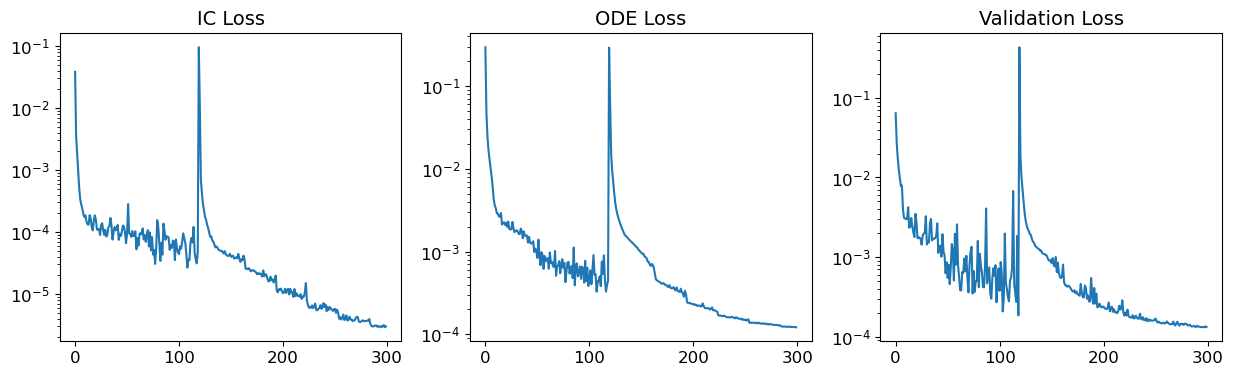

In [15]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Validation Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)
    
plt.savefig('loss.png', bbox_inches='tight', pad_inches=0, transparent=True)

In [16]:
# Create new model instance
PI_DeepONet = create_model(mean, var)

# Reload the saved model
PI_DeepONet.load_weights('NN_model.h5')

In [17]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
# Make prediction
pred_test = PI_DeepONet.predict({"forcing": X_test[:, 1:-1], "time": X_test[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten()):.4e}")

1/1 [==============================] - 0s 98ms/step
RMSE: 5.4966e-06


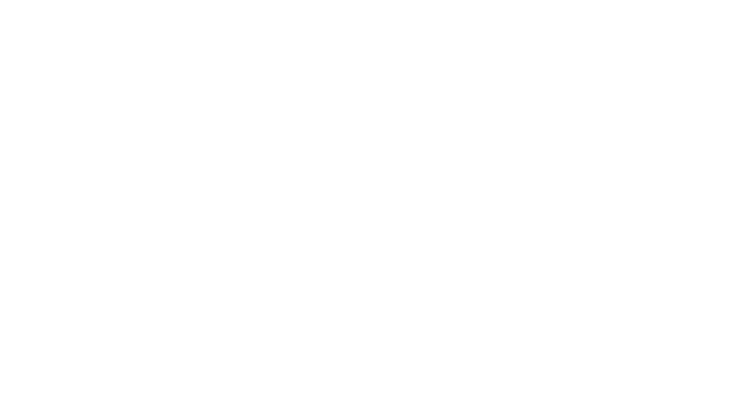

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.animation import FuncAnimation


# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Define the initialization function
def init():
    # Set up the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {0}")
    ax.tick_params(axis='both', which='major', labelsize=12)

    return ax,

# Define the update function
def update(epoch):
    # Clear the previous frame
    ax.cla()
    
    # Plot the loss convergence
    pred, = ax.plot(np.linspace(0, 1, 100), pred_profiles[epoch].flatten(), label="Prediction")
    truth, = ax.plot(np.linspace(0, 1, 100), y_test[25*100:(25+1)*100, :], label="Ground Truth")
    ax.legend(prop={'size': 12})  
    
    # Set the axes limits (if necessary)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.15, 0.01)
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.set_title(f"Epochs: {epoch}")
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    return line
    

# Create the animation
n_epochs = len(loss_tracker.loss_history['IC_loss'])  # Replace with the total number of epochs
frames = range(0, n_epochs, 2)
animation = FuncAnimation(fig, update, frames=frames, init_func=init, blit=True, interval=50)

# Display the animation
plt.show()

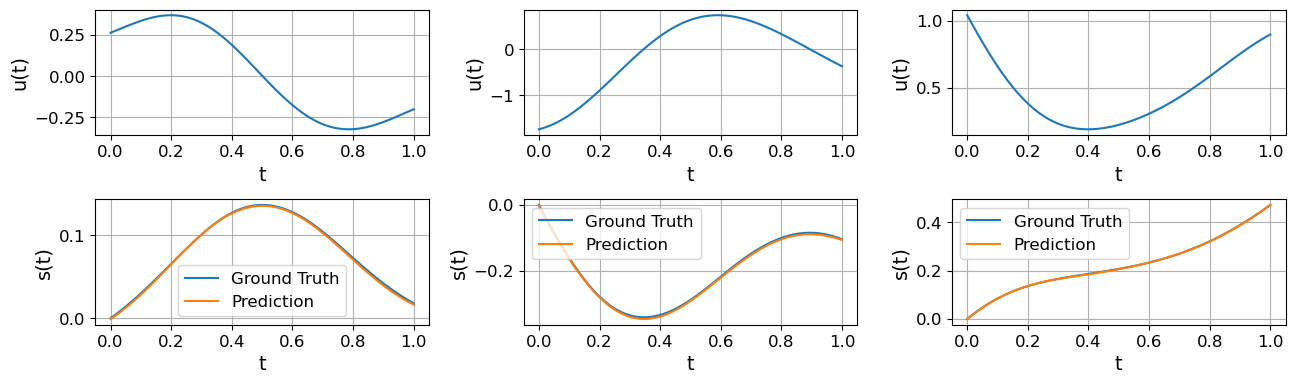

In [19]:
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    
    
    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred_test[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

plt.tight_layout()
plt.savefig('testing.png', bbox_inches='tight', transparent=True)

In [20]:
# Create test dataset
N_test = 100
length_scale_test = 0.2
X, y = generate_dataset(N_test, length_scale_test, ODE_solve=True)

100%|██████████| 100/100 [00:00<00:00, 626.92it/s]


In [21]:
# Make prediction
pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

# Overall accuarcy
print(f"RMSE: {mean_squared_error(y.flatten(), pred.flatten(), squared=False):.4e}")

1/1 [==============================] - 0s 24ms/step
RMSE: 5.6495e-02


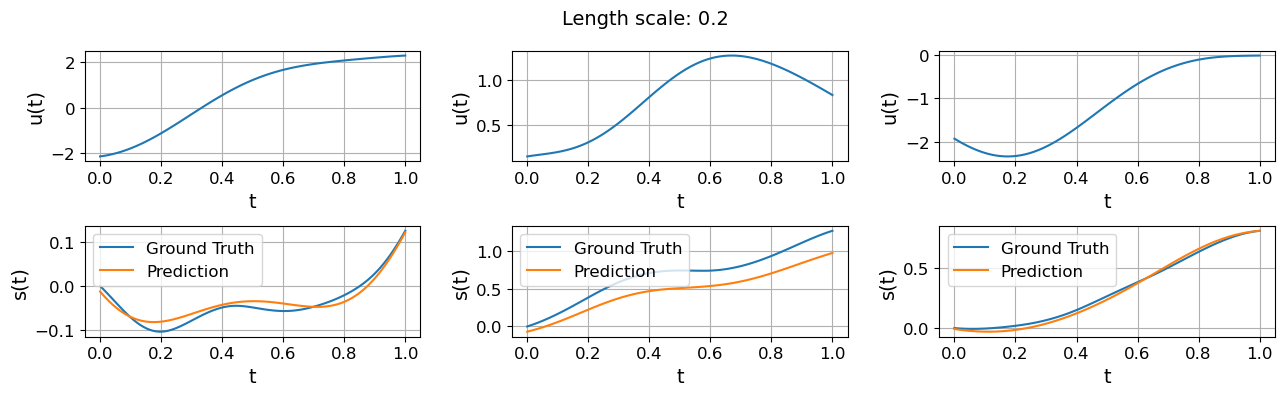

In [22]:
# Spot check
%matplotlib inline
fig, axs = plt.subplots(2, 3, figsize=(13, 4))
sample_id = np.random.choice(np.arange(0, 100), size=3, replace=False)
for i in range(3):
    ax = axs[0, i]
    ax.plot(np.linspace(0, 1, 100), X_test[sample_id[i]*100, 1:-1])
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('u(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    
    
    ax = axs[1, i]
    ax.plot(np.linspace(0, 1, 100), y[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Ground Truth")
    ax.plot(np.linspace(0, 1, 100), pred[sample_id[i]*100:(sample_id[i]+1)*100, :], label="Prediction")
    ax.set_xlabel('t', fontsize=14)
    ax.set_ylabel('s(t)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.grid(True)
    ax.legend(prop={'size': 12})

fig.suptitle(f'Length scale: {length_scale_test}', fontsize=14)
plt.tight_layout()
plt.savefig('testing_OOD.png', bbox_inches='tight', transparent=True)

In [23]:
length_scale_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
RMSE = []
for length_scale in length_scale_list:
    # Create test dataset
    N_test = 100
    X, y = generate_dataset(N_test, length_scale, ODE_solve=True)
    
    # Make prediction
    pred = PI_DeepONet.predict({"forcing": X[:, 1:-1], "time": X[:, :1]}, batch_size=12800)

    # Overall accuarcy
    RMSE.append(mean_squared_error(y.flatten(), pred.flatten(), squared=False))

100%|██████████| 100/100 [00:00<00:00, 472.77it/s]

1/1 [==============================] - 0s 22ms/step



100%|██████████| 100/100 [00:00<00:00, 563.22it/s]


1/1 [==============================] - 0s 24ms/step


100%|██████████| 100/100 [00:00<00:00, 659.87it/s]


1/1 [==============================] - 0s 25ms/step


100%|██████████| 100/100 [00:00<00:00, 760.09it/s]


1/1 [==============================] - 0s 22ms/step


100%|██████████| 100/100 [00:00<00:00, 849.35it/s]


1/1 [==============================] - 0s 22ms/step


100%|██████████| 100/100 [00:00<00:00, 806.28it/s]


1/1 [==============================] - 0s 26ms/step


100%|██████████| 100/100 [00:00<00:00, 740.81it/s]


1/1 [==============================] - 0s 23ms/step


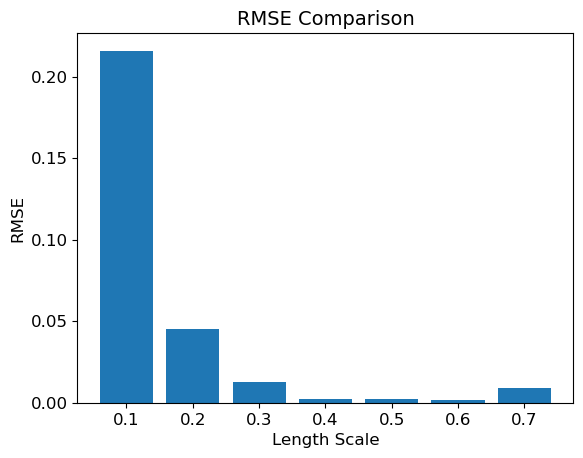

In [24]:
# Generate bar plot
plt.bar(range(len(RMSE)), RMSE)

# Set x-axis tick labels
plt.xticks(range(len(RMSE)), length_scale_list)

# Set x and y axis labels
plt.xlabel('Length Scale', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Set a title for the plot
plt.title('RMSE Comparison', fontsize=14)

# Save the plot
plt.savefig('testing_OOD_bar.png', bbox_inches='tight', transparent=True)